In [1]:
import numpy
import gym

GAME_NAME = 'CartPole-v0'

env = gym.make(GAME_NAME)
    
GAME_ACTIONS = env.action_space.n
GAME_OBS = env.observation_space.shape[0]

print(GAME_ACTIONS)
print(GAME_OBS)

env.reset()
env.close()

2
4


C:\Users\my\anaconda3\envs\gymzero\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import deepcopy
from math import *
import random

c = 2.0

class Node:

    def __init__(self, game, done, parent, observation, action_index):
          
        # child nodes
        self.child = None
        
        # total rewards from MCTS exploration
        self.T = 0
        
        # visit count
        self.N = 0        
                
        # the environment
        self.game = game
        
        # observation of the environment
        self.observation = observation
        
        # if game is won/loss/draw
        self.done = done

        # link to parent node
        self.parent = parent
        
        # action index that leads to this node
        self.action_index = action_index
        
        
    def getUCBscore(self):
        
        if self.N == 0:
            return float('inf')
        
        top_node = self
        while top_node.parent:
            top_node = top_node.parent
            
        return (self.T / self.N) + c * sqrt(log(top_node.N) / self.N)
    
    
    def detach_parent(self):
        del self.parent
        self.parent = None
       
        
    def create_child(self):
        
        if self.done:
            return
    
        actions = []
        games = []
        for i in range(GAME_ACTIONS): 
            actions.append(i)           
            new_game = deepcopy(self.game)
            games.append(new_game)
            
        child = {} 
        for action, game in zip(actions, games):
            observation, reward, done, _ = game.step(action)
            child[action] = Node(game, done, self, observation, action)                        
            
        self.child = child
                
            
    def explore(self):
        
        # find a leaf node by choosing nodes with max U.
        
        current = self
        
        while current.child:

            child = current.child
            max_U = max(c.getUCBscore() for c in child.values())
            actions = [ a for a,c in child.items() if c.getUCBscore() == max_U ]
            if len(actions) == 0:
                print("error zero length ", max_U)                      
            action = random.choice(actions)
            current = child[action]
            
        # play a random game, or expand if needed          
            
        if current.N < 1:
            current.nn_v = current.rollout()
            current.T = current.T + current.nn_v
        else:
            current.create_child()
            if current.child:
                current = random.choice(current.child)
            current.nn_v = current.rollout()
            current.T = current.T + current.nn_v
            
        current.N += 1      
                
        # update statistics and backpropagate
            
        parent = current
            
        while parent.parent:
            
            parent = parent.parent
            parent.N += 1
            parent.T = parent.T + current.T           
            
            
    def rollout(self):
        
        if self.done:
            return 0        
        
        v = 0
        done = False
        new_game = deepcopy(self.game)
        while not done:
            action = new_game.action_space.sample()
            observation, reward, done, _ = new_game.step(action)
            v = v + reward
            if done:
                new_game.reset()
                new_game.close()
                break             
        return v

    
    def next(self):

        if self.done:
            raise ValueError("game has ended")

        if not self.child:
            raise ValueError('no children found and game hasn\'t ended')
        
        child = self.child
        
        max_N = max(node.N for node in child.values())
       
        max_children = [ c for a,c in child.items() if c.N == max_N ]
        
        if len(max_children) == 0:
            print("error zero length ", max_N) 
            
        max_child = random.choice(max_children)
        
        return max_child, max_child.action_index

In [3]:
from copy import deepcopy
import random

MCTS_POLICY_EXPLORE = 500

def Policy_Player_MCTS(mytree):  
    
    for i in range(MCTS_POLICY_EXPLORE):
        mytree.explore()
        
    next_tree, next_action = mytree.next()
        
    next_tree.detach_parent()
    
    return next_tree, next_action

C:\Users\my\anaconda3\envs\gymzero\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


episode #1
reward_e 117.0


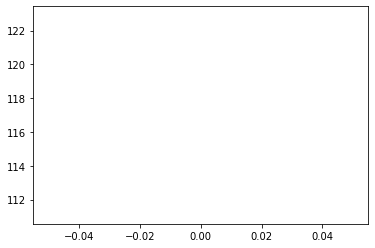

moving average: 117.0
episode #2
reward_e 200.0


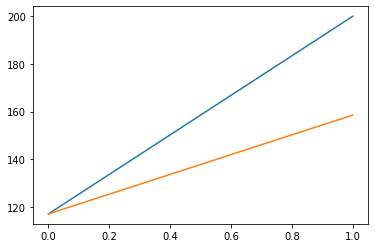

moving average: 158.5
episode #3
reward_e 99.0


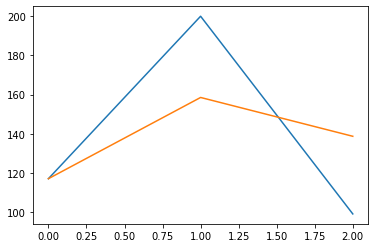

moving average: 138.66666666666666
episode #4
reward_e 122.0


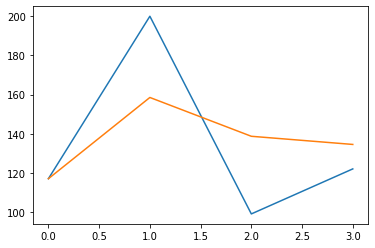

moving average: 134.5
episode #5
reward_e 160.0


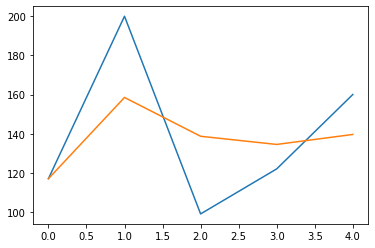

moving average: 139.6
episode #6
reward_e 121.0


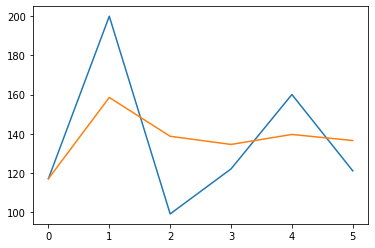

moving average: 136.5
episode #7
reward_e 126.0


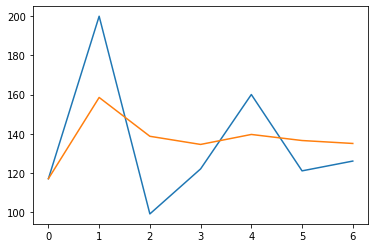

moving average: 135.0
episode #8
reward_e 117.0


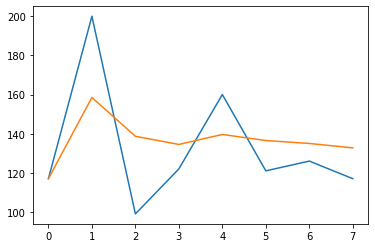

moving average: 132.75
episode #9
reward_e 117.0


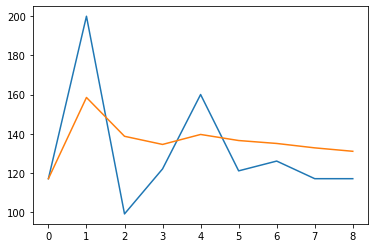

moving average: 131.0
episode #10
reward_e 200.0


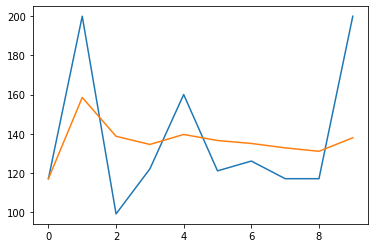

moving average: 137.9
episode #11
reward_e 200.0


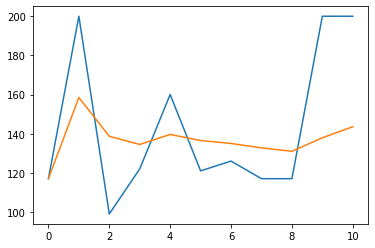

moving average: 143.54545454545453
episode #12
reward_e 200.0


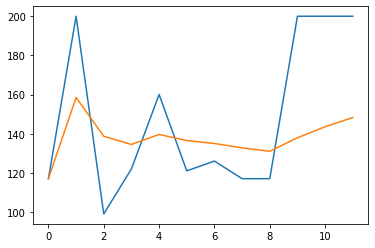

moving average: 148.25
episode #13
reward_e 200.0


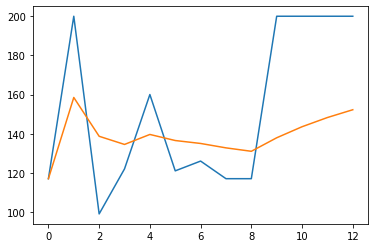

moving average: 152.23076923076923
episode #14
reward_e 94.0


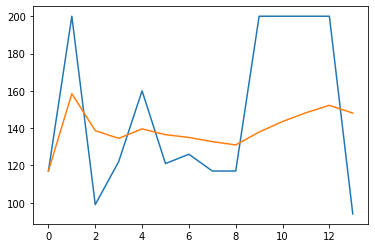

moving average: 148.07142857142858
episode #15
reward_e 200.0


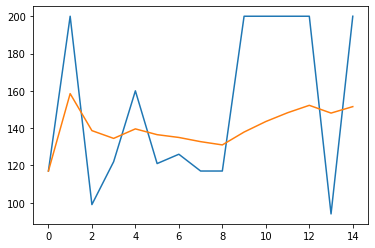

moving average: 151.53333333333333
episode #16
reward_e 102.0


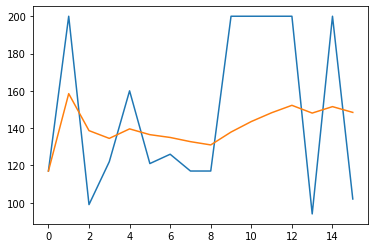

moving average: 148.4375
episode #17
reward_e 141.0


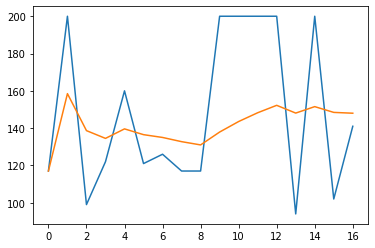

moving average: 148.0
episode #18
reward_e 131.0


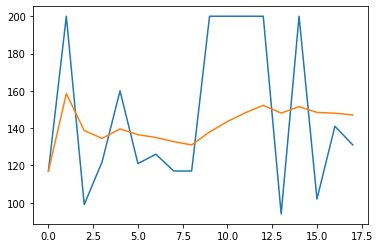

moving average: 147.05555555555554
episode #19
reward_e 128.0


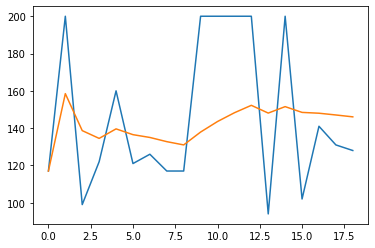

moving average: 146.05263157894737
episode #20
reward_e 200.0


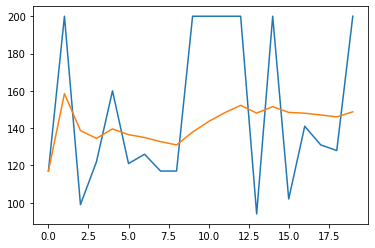

moving average: 148.75
episode #21
reward_e 123.0


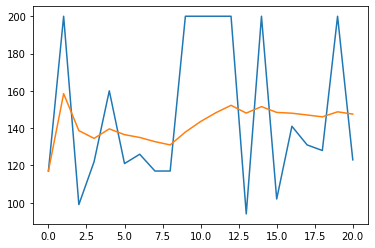

moving average: 149.05
episode #22


In [ ]:
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output

episodes = 5000
rewards = []
moving_average = []

for e in range(episodes):

    reward_e = 0    
    game = gym.make(GAME_NAME)
    observation = game.reset() 
    done = False
    
    new_game = deepcopy(game)
    mytree = Node(new_game, False, 0, observation, 0)
    
    print('episode #' + str(e+1))
    
    while not done:
    
        mytree, action = Policy_Player_MCTS(mytree)
        
        observation, reward, done, _ = game.step(action)  
                        
        reward_e = reward_e + reward
                
        if done:
            print('reward_e ' + str(reward_e))
            game.close()
            break
        
    rewards.append(reward_e)
    moving_average.append(np.mean(rewards[-100:]))
    
    plt.plot(rewards)
    plt.plot(moving_average)
    plt.show()
    print('moving average: ' + str(np.mean(rewards[-20:])))